# Case Study Analysis Notebook

The purpose of this code is to create a set of graphs based on one shapefile.  It is a combination of many of the other notebooks consolidated into this one.

To run this code, you need the following files in the appropriate folders
 - 

In [121]:
# Packages and paths
# %%
from optparse import Values
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import datetime
from matplotlib.transforms import Bbox
import numpy as np
import pandas as pd
from shapely.geometry import box
import geopandas as gp
#import earthpy as et
import scipy.stats as sp
from scipy.stats import kendalltau, pearsonr, spearmanr
import pymannkendall as mk
import Custom_functions as cf

# Local paths
datapath_local = '../Data'
inputpath_local = '../Data/Input_files'
outputpath_local = '../Data/Output_files/'
shapepath_local = '../Data/Shapefiles/'
figurepath = '../Data/Figures/'

# Some functions
def kendall_pval(x,y):
        return kendalltau(x,y)[1]
    
def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]
    
def spearmanr_pval(x,y):
        return spearmanr(x,y)[1]

In [19]:
# %% Creating colors
c_1 = '#8d5a99' # Reservation
c_2 = "#d7191c" # Regulated with CAP (Water Category Color)
c_3 = '#e77a47' # Regulated without CAP (Water Category Color)
c_4 = '#2cbe21' # Lower CO River - SW (Water Category Color)
c_5 = '#2f8c73' # Upper CO River - Mixed (Water Category Color)
c_6 = '#6db7e8' # SE - GW
c_7 = '#165782' # NW - GW (Water Category color)
c_8 = '#229ce8' # SC - GW
c_9 = '#1f78b4' # NE - GW
c_10 = '#41bf9e' # N - Mixed
c_11 = '#7adec4' # C - Mixed
drought_color = '#ffa6b8'
wet_color = '#b8d3f2'

reg_colors = [c_2,c_7]
georeg_colors = [c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11]
SW_colors = [c_2,c_3,c_4,c_5,c_7]

bar_watercatc = [c_2,c_3,c_4,c_5,c_7]


# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
blind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# Matching new map

grace_color = '#A92B2A'
az_wells_color = '#1D4E77'

cap = '#77A8A5' #'#C6652B'
cap_secondary = '#004D40'
# noCAP = '#EDE461' # This is one from the map
noCAP = '#CCC339' # This color but darker for lines
GWdom = '#3B76AF'
mixed = '#6EB2E4'
swdom = '#469B76'

In [25]:
# %% Drought dictionary
DROUGHT_YEARS = {
        # 1:[1989,1990]
        # ,2:[1996]
        3:[2002,2003]
        ,4:[2006,2007]
        ,5:[2012,2013,2014]
        ,6:[2018]
        ,7:[2021]}

print(DROUGHT_YEARS)

{3: [2002, 2003], 4: [2006, 2007], 5: [2012, 2013, 2014], 6: [2018], 7: [2021]}


In [26]:
#%% Pre-drought
# PREDROUGHT_YEARS = {1:[1988]
#         ,2:[1995]
#         ,3:[2001]
#         ,4:[2005]
#         ,5:[2011]
#         ,6:[2017]}

PREDROUGHT_YEARS = {1:[*range(1975,1988,1)]
        ,2:[*range(1991,1995,1)]
        ,3:[*range(1997,2001,1)]
        ,4:[*range(2004,2005,1)]
        ,5:[*range(2006,2011,1)]
        ,6:[*range(2015,2017,1)]}

print(PREDROUGHT_YEARS)

{1: [1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987], 2: [1991, 1992, 1993, 1994], 3: [1997, 1998, 1999, 2000], 4: [2004], 5: [2006, 2007, 2008, 2009, 2010], 6: [2015, 2016]}


Read in the main databases.  You only have to do this once.

Master Database might take a while (~5 minutes).

In [4]:
# Read in the main Static Database

filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
filepath = os.path.join(inputpath_local, filename_mdb_nd)
print(filepath)

masterdb = gp.read_file(filepath)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb.info())

../Data/Input_files/Master_ADWR_database_noduplicates.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 250870 entries, 0 to 250869
Data columns (total 72 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Combo_ID    250870 non-null  object  
 1   SITE_ID     45565 non-null   object  
 2   LOCAL_ID    45565 non-null   object  
 3   REGISTRY_I  229717 non-null  object  
 4   WELL_TYPE   45565 non-null   object  
 5   DD_LAT      45565 non-null   float64 
 6   DD_LONG     45565 non-null   float64 
 7   WELL_ALT    45565 non-null   float64 
 8   WATER_USE_  45507 non-null   object  
 9   WELL_DEPTH  221075 non-null  float64 
 10  CASE_DIAM   45565 non-null   float64 
 11  LASTWLDATE  34356 non-null   object  
 12  WL_DTW      45565 non-null   float64 
 13  WL_ELEV     45565 non-null   float64 
 14  QUASI_IDX_  11 non-null      object  
 15  GOES_ENABL  171 non-null     object  
 16  TRANSDUCER  171 non-null     object  
 17  I

This one takes about 3 minutes to run

In [50]:
# Read in the database of number water wells
filename_mdb_w = 'Master_ADWR_database_water.shp'
filepath = os.path.join(inputpath_local, filename_mdb_w)
print(filepath)

masterdb_water = gp.read_file(filepath)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb_water.info())

../Data/Input_files/Master_ADWR_database_water.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140185 entries, 0 to 140184
Data columns (total 72 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Combo_ID    140185 non-null  object  
 1   SITE_ID     45565 non-null   object  
 2   LOCAL_ID    45565 non-null   object  
 3   REGISTRY_I  119032 non-null  object  
 4   WELL_TYPE   45565 non-null   object  
 5   DD_LAT      45565 non-null   float64 
 6   DD_LONG     45565 non-null   float64 
 7   WELL_ALT    45565 non-null   float64 
 8   WATER_USE_  45507 non-null   object  
 9   WELL_DEPTH  139606 non-null  float64 
 10  CASE_DIAM   45565 non-null   float64 
 11  LASTWLDATE  34356 non-null   object  
 12  WL_DTW      45565 non-null   float64 
 13  WL_ELEV     45565 non-null   float64 
 14  QUASI_IDX_  11 non-null      object  
 15  GOES_ENABL  171 non-null     object  
 16  TRANSDUCER  171 non-null     object  
 17  IDXBK2  

In [3]:
# Read in the annual time series database
# This file was created in Well_Timeseries_merge.py

filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated_thresh15outliersdeleted.csv'
filepath = os.path.join(outputpath_local, filename_ts)
print(filepath)
annual_db = pd.read_csv(filepath, header=1, index_col=0)

#Block to do some formatting
annual_db = annual_db[1:168102]
annual_db.index = annual_db.index.astype('int64')
annual_db2 = annual_db.reset_index(inplace=True)
annual_db2 = annual_db.rename(columns = {'year':'Combo_ID'})
annual_db2.head()

../Data/Output_files/Wells55_GWSI_WLTS_DB_annual_updated_thresh15outliersdeleted.csv


,Combo_ID,1853.0,1856.0,1857.0,1860.0,1864.0,1868.0,1870.0,1871.0,1872.0,...,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
0,60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,503.900,497.70,495.300,NaN,489.850000,NaN,487.85,485.100000,483.50,NaN
1,85358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,264.725,NaN,262.430,254.885000,251.650000,251.53,NaN,NaN,NaN,NaN
2,85761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.900,44.70,45.500,45.300000,46.300000,45.00,46.20,43.500000,NaN,NaN
3,85799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.900,59.30,59.800,57.800000,59.500000,60.10,59.40,60.800000,62.10,NaN
4,85863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,112.640,114.74,115.505,116.263333,117.103333,119.34,118.49,119.773333,120.65,118.66


### From here down is where you can rerun the code to generate graphs

<Axes: >

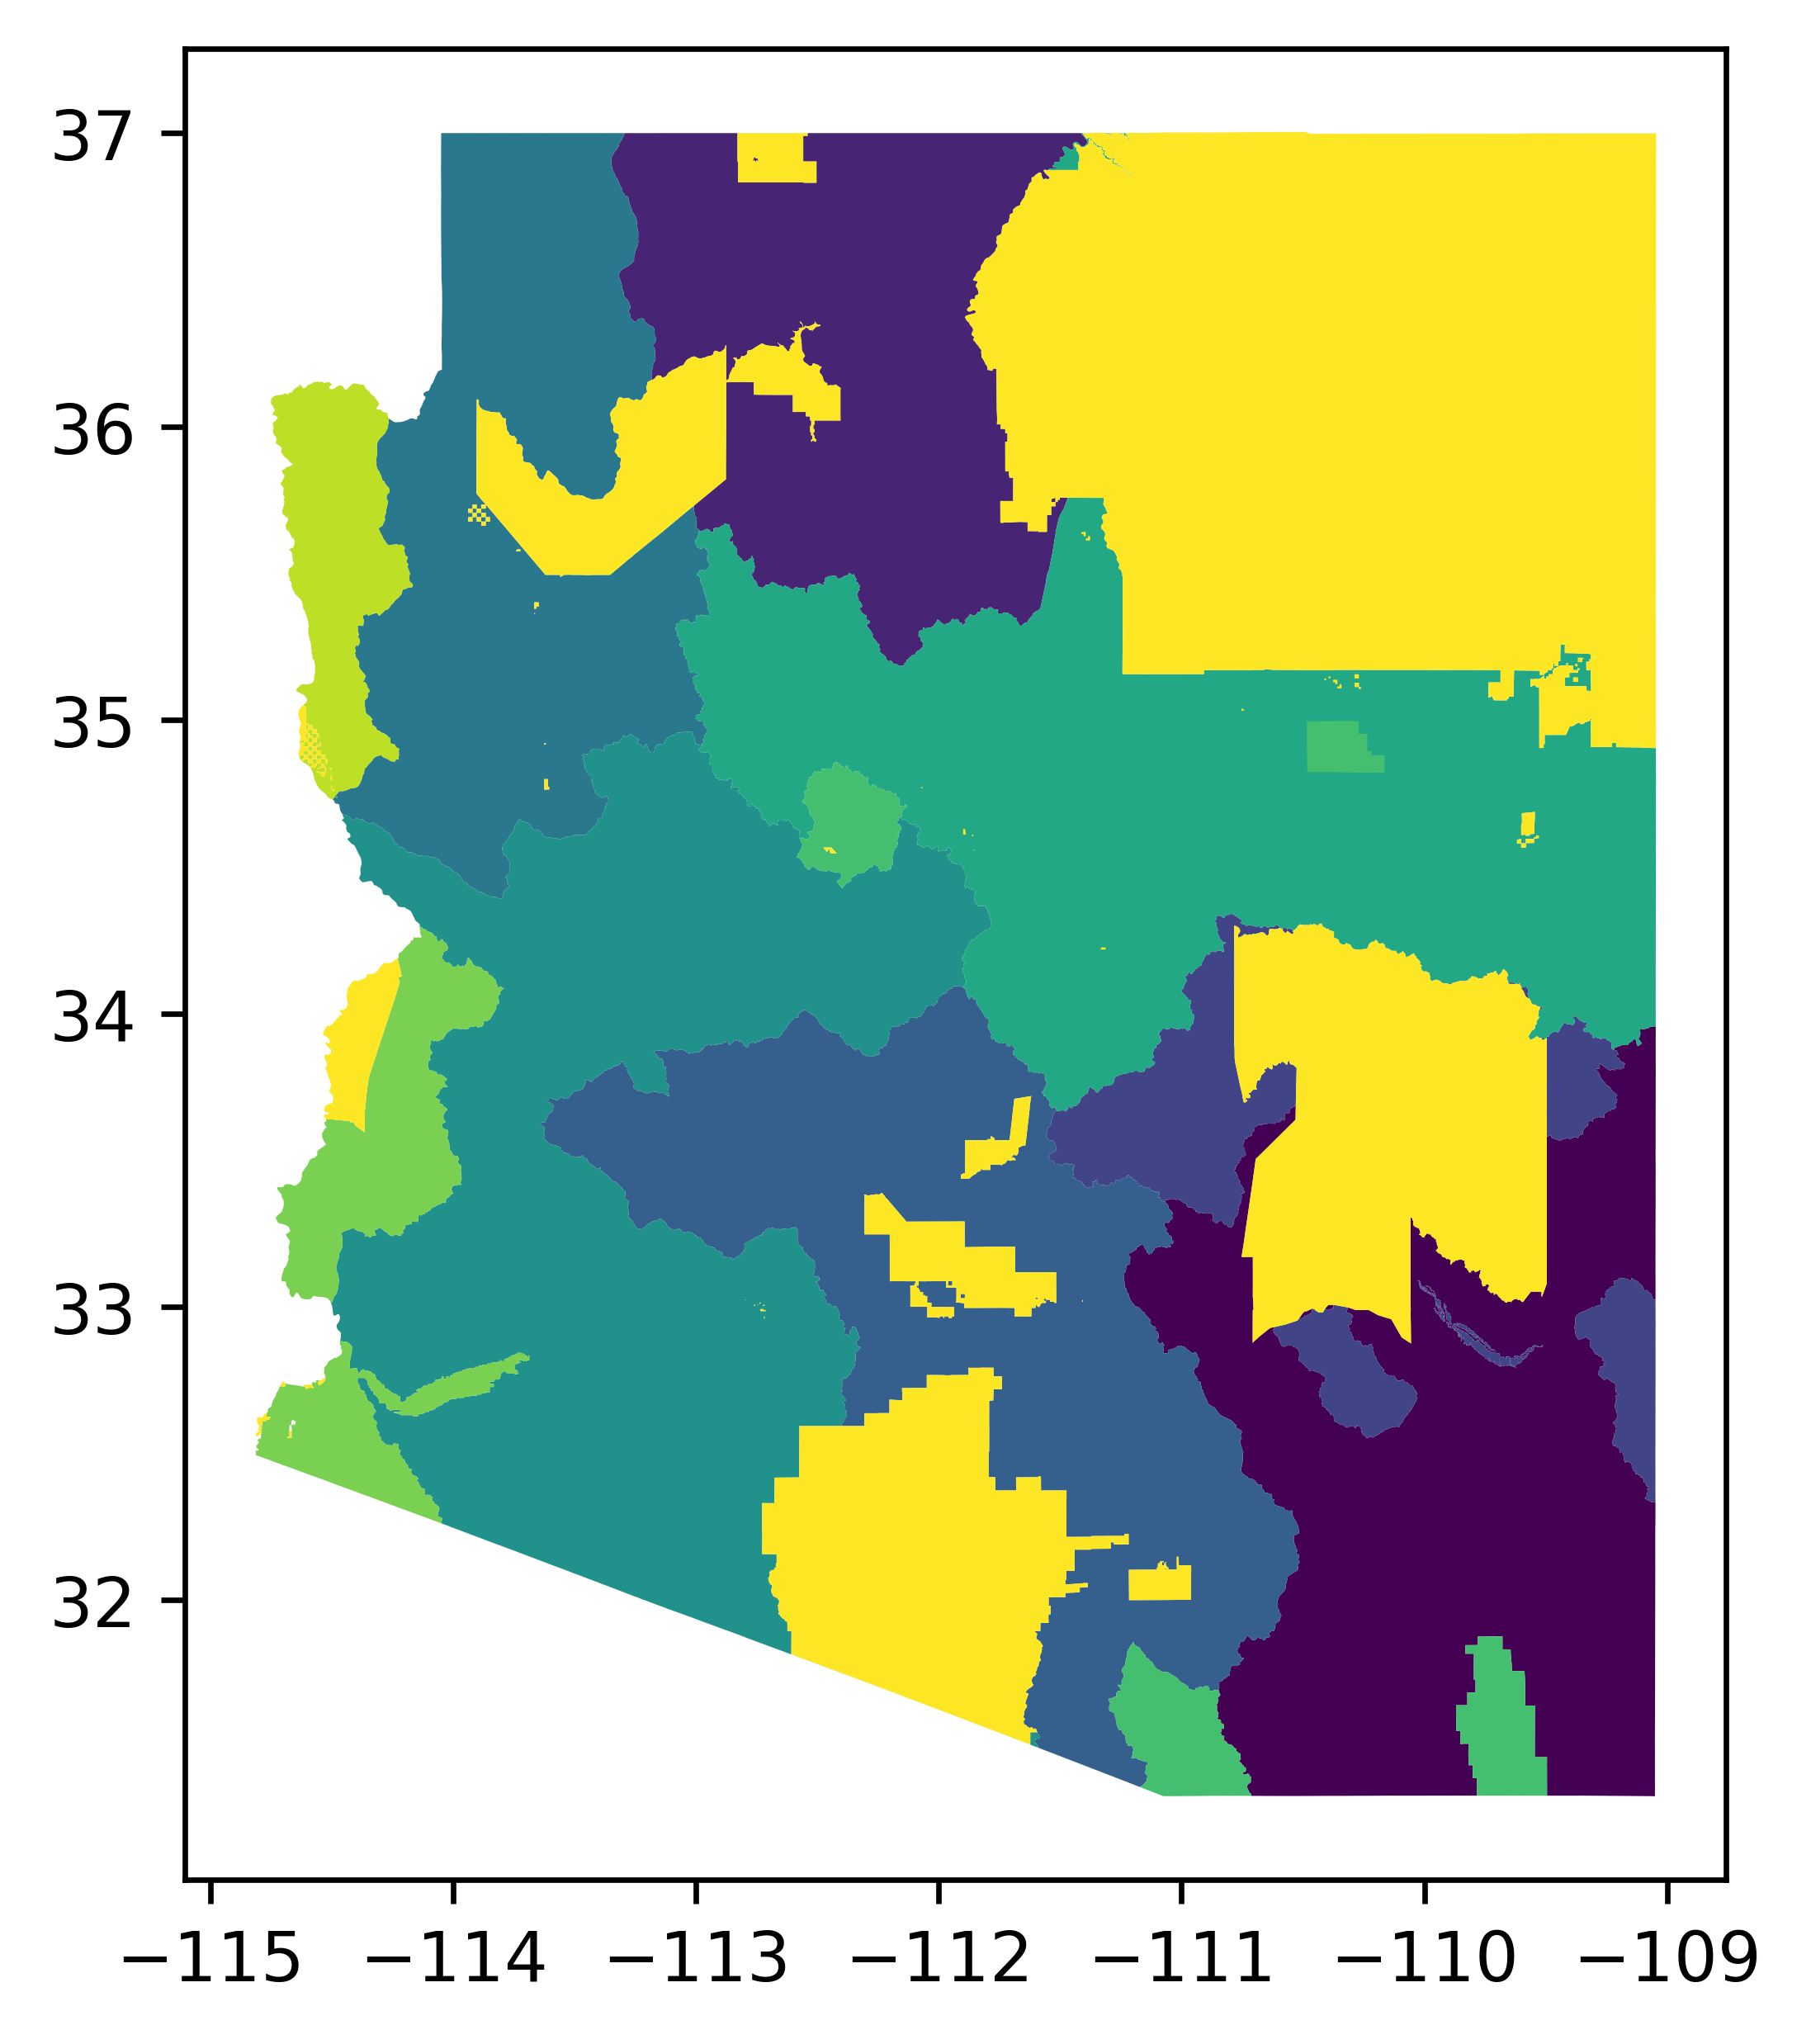

In [54]:
# Read in the shapefile

filename_shapeile = 'georeg_reproject_fixed.shp'
filepath = os.path.join(shapepath_local, filename_shapeile)
shapefile = gp.read_file(filepath)
shapefile.plot(cmap='viridis')


In [122]:
# Define some things about your file

StudyArea = "Test"
Naming_col = "Regulation" 

Merging the databases takes a little time - Approximately 3 minutes

In [123]:
# Merge the shapefile with the master database

shapefile = shapefile.to_crs(epsg=26912)
masterdb2 = masterdb.set_crs(epsg=26912)
masterdb_water = masterdb_water.set_crs(epsg=26912)
# For main static database
static_geo = gp.sjoin(masterdb2, shapefile, how="inner", op='intersects')

print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")

# %% For the water wells water wells
static_geo2 = gp.sjoin(masterdb_water, shapefile, how="inner", op='intersects')
static_geo2.head()
print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")


/Users/danielletadych/opt/miniconda3/envs/azdroughtanalysis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NameError: name 'filename_shapeile' is not defined

In [59]:
# Pull out the columns you need
reg_list = static_geo[['Combo_ID', Naming_col,'WELL_DEPTH','WELL_TYPE_']]
reg_list

# %% Converting Combo_ID to int
reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_92297/257690895.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')


In [60]:
# Merging the Timeseries and the shapefile static database
combo = annual_db2.merge(reg_list, how="inner")
combo.info()

# %% set index to Combo_ID
combo.set_index('Combo_ID', inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1785 entries, 0 to 1784
Columns: 163 entries, Combo_ID to WELL_TYPE_
dtypes: float64(160), int64(1), object(2)
memory usage: 2.2+ MB


In [61]:
# Grouping the appropriate column
combo_copy = combo.copy()
combo_copy = combo_copy.drop(['WELL_DEPTH','WELL_TYPE_'],axis=1)
cat_wl = combo_copy.groupby([Naming_col]).mean()

In [62]:
# Clean up the dataframe for graphing
cat_wl2 = cat_wl.copy()
i = cat_wl2
# del i['WELL_DEPTH']
f = i.transpose()
f.reset_index(inplace=True)
f['index'] = pd.to_numeric(f['index'])
f['index'] = f['index'].astype(int)
f.set_index('index', inplace=True)
f.info()
cat_wl2 = f
cat_wl2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 1853 to 2023
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   R       104 non-null    float64
 1   Res     64 non-null     float64
 2   U       103 non-null    float64
dtypes: float64(3)
memory usage: 5.0 KB


Regulation,R,Res,U
index,,,
1853,NaN,NaN,NaN
1856,NaN,NaN,NaN
1857,NaN,NaN,NaN
1860,NaN,NaN,NaN
1864,NaN,NaN,NaN
...,...,...,...
2019,232.38,46.01,226.79
2020,232.11,46.66,226.74
2021,233.49,45.67,235.17


In [63]:
# Export the dataframe
# cat_wl2_reg.to_csv(outputpath_local+'Waterlevels_Regulation_updated_thresh15outliersdeleted.csv')

### Analysis and Graphing

In [64]:
# Read in the drought indices
# drought_indices = pd.read_csv(datapath+'Yearly_DroughtIndices.csv')
drought_indices = pd.read_csv(inputpath_local+'/Yearly_DroughtIndices_updated12032023.csv') #this version doesn't have PHDI so adjust accordingly
drought_indices = drought_indices.set_index('In_year')
# drought_indices

In [65]:
Min_year_of_Study = 2000

# Water Analysis period
wlanalysis_period = cat_wl2[(cat_wl2.index>=Min_year_of_Study)&(cat_wl2.index<=2022)]
drought_indices = drought_indices[(drought_indices.index>=Min_year_of_Study)&(drought_indices.index<=2022)]
del wlanalysis_period['Res'] # Only run this if doing regulation shapefile
wlanalysis_period.head()

Regulation,R,U
index,,
2000,250.55,217.72
2001,237.57,220.88
2002,246.74,216.85
2003,247.43,218.17
2004,245.25,211.64


In [67]:
ds = wlanalysis_period
# %% If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0
indice = 'PDSI'


columns = ds.columns
column_list = ds.columns.tolist()

print('Kendall Correlation coefficient')
for i in column_list:
        # print(' '+i+':')
        print(' '+str(i)+':')
# To normalize the data 
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices[indice].shift(lag)
        print('  tau = ',round(df1.corr(df2, method='kendall'),3))
        print('  pval = ',round(df1.corr(df2, method=kendall_pval),4))

# %%
print('Spearman Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices[indice].shift(lag)
        print('  rho = ',round(df1.corr(df2, method='spearman'),3))
        print('  pval = ',round(df1.corr(df2, method=spearmanr_pval),4))

# %%
print('Pearson Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices[indice].shift(lag)
        r = df1.corr(df2, method='pearson')
        print('  rsq = ',round(r*r,3))
        print('  pval = ',round(df1.corr(df2, method=pearsonr_pval),4))

Kendall Correlation coefficient
 R:
  tau =  -0.202
  pval =  0.1888
 U:
  tau =  -0.012
  pval =  0.9584
Spearman Correlation coefficient
 R:
  rho =  -0.303
  pval =  0.1594
 U:
  rho =  0.017
  pval =  0.9394
Pearson Correlation coefficient
 R:
  rsq =  0.056
  pval =  0.2778
 U:
  rsq =  0.001
  pval =  0.9113


         Regulated  Unregulated
slope        -0.76         0.54
int        1771.21      -858.66
rsq           0.71         0.37
p_val         0.00         0.00
std_err       0.11         0.15
mean        239.50       221.00
var          36.05        34.55
sum        5508.59      5082.96


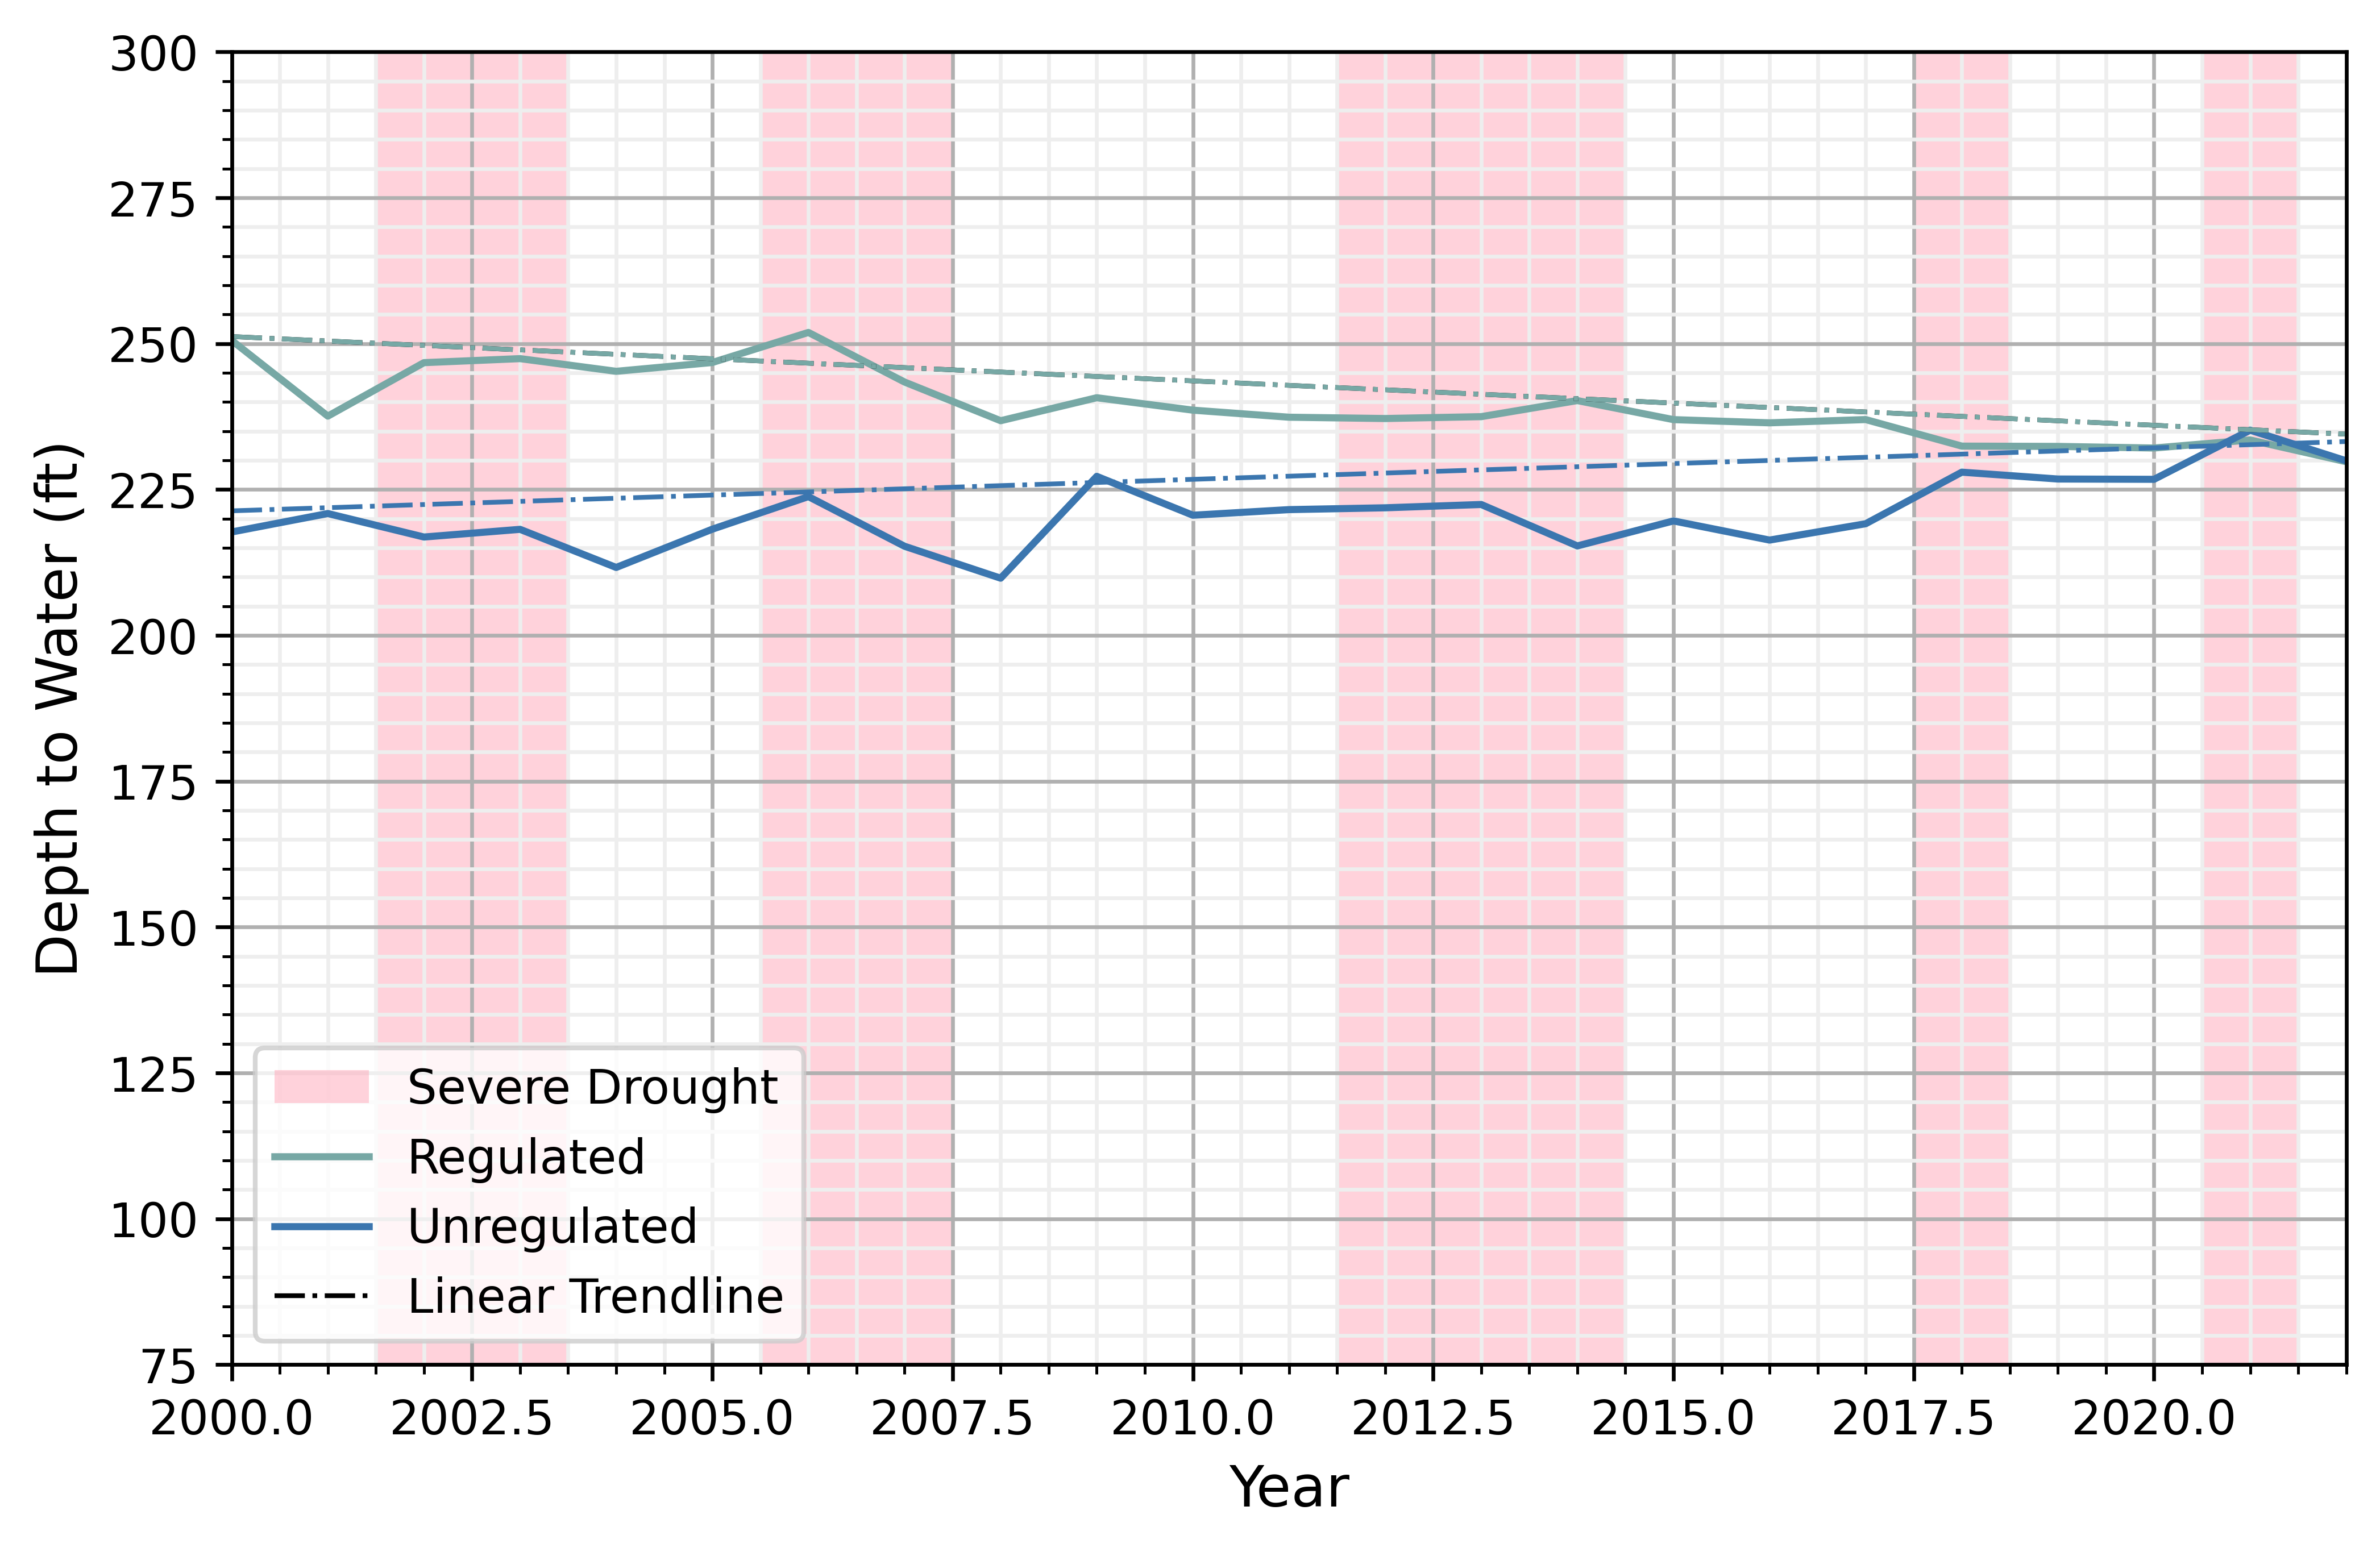

In [68]:
# For Depth to Water by regulation
ds = wlanalysis_period
min_yr = 2000
mx_yr = 2022
Name = "mean_"+StudyArea

betterlabels = ['Regulated','Unregulated']
# betterlabels = StudyArea

f = ds[(ds.index >= min_yr) & (ds.index <= mx_yr)]
columns = ds.columns
column_list = ds.columns.tolist()

stats = pd.DataFrame()
# for i in range(1, 12, 1):
for i in column_list:
        df = f[i]
        #print(df)
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
        stats = stats._append({'slope': slope, 
                              'int':intercept, 
                              'rsq':r_value*r_value, 
                              'p_val':p_value, 
                              'std_err':std_err, 
                              'mean': np.mean(y),
                              'var': np.var(y),
                              'sum': np.sum(y)
                              },
                              ignore_index=True)


stats.index = betterlabels
stats1 = stats.transpose()
print(stats1)

# -- Data visualization --
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()
#xf1 = pd.to_datetime(xf1)
m1 = round(stats1.loc['slope','Regulated'], 2)
m2 = round(stats1.loc['slope','Unregulated'], 2)
yint1 = round(stats1.loc['int','Regulated'], 2)
yint2 = round(stats1.loc['int','Unregulated'], 2)
pval1 = round(stats1.loc['p_val', 'Regulated'], 4)
pval2 = round(stats1.loc['p_val', 'Unregulated'], 4)

yf1 = (m1*xf)+yint1
yf2 = (m2*xf)+yint2

fig, ax = plt.subplots(1, 1, figsize = (8,5))

min_y = 75
max_y = 300
fsize = 12

# Drought Year Shading
a = 1988.5
b = 1990.5
c = 1995.5
d = 1996.5
e = 2020.5
f = 2021.5
g = 2001.5
h = 2003.5
i = 2005.5
j = 2007.5
k = 2011.5
l = 2014.5
m = 2017.5
n = 2018.5
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0
            , label="Severe Drought"
            )
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)

ax.plot(ds['R'], label='Regulated', color=cap) 
ax.plot(ds['U'], label='Unregulated', color=GWdom) 

ax.plot(xf1, yf1,"-.",color='k',label='Linear Trendline', lw=1)
ax.plot(xf1, yf1,"-.",color=cap, lw=1)
ax.plot(xf1, yf2,"-.",color=GWdom, lw=1)

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(min_y,max_y)
# ax.grid(True)
ax.grid(visible=True,which='major')
ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('Depth to Water (ft)',fontsize=fsize)
ax.minorticks_on()
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='lower left')

# #Putting Grace on a secondary axis
# ax2 = ax.twinx()
# ax2.plot(grace_yearly['0'], label='State Average LWE', color='k',zorder=1)
# ax2.set_ylim([15, -15])
# ax2.set_ylabel(u'Δ LWE (cm)',fontsize=fsize)
# ax2.legend(loc='lower right')

# plt.savefig(figurepath+Name, bbox_inches = 'tight')

In [36]:
# Anomaly's
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()
trend_df = wlanalysis_period.copy()
dtw_anomalys = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        # print(y)
        # slope, intercept = sp.linregress(x,y) 
        trend_df[i] = (wlanalysis_period.index*slope) + intercept
        dtw_anomalys[i] = wlanalysis_period[i] - trend_df[i]
        

dtw_anomalys.head()

,R,U
index,,
2000,2.67,2.62
2001,-9.55,5.25
2002,0.38,0.69
2003,1.83,1.47
2004,0.42,-5.60


In [37]:
ds = dtw_anomalys
# %% If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0
indice = 'PDSI'


columns = ds.columns
column_list = ds.columns.tolist()

print('Kendall Correlation coefficient')
for i in column_list:
        # print(' '+i+':')
        print(' '+str(i)+':')
# To normalize the data 
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices[indice].shift(lag)
        print('  tau = ',round(df1.corr(df2, method='kendall'),3))
        print('  pval = ',round(df1.corr(df2, method=kendall_pval),4))

# %%
print('Spearman Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices[indice].shift(lag)
        print('  rho = ',round(df1.corr(df2, method='spearman'),3))
        print('  pval = ',round(df1.corr(df2, method=spearmanr_pval),4))

# %%
print('Pearson Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices[indice].shift(lag)
        r = df1.corr(df2, method='pearson')
        print('  rsq = ',round(r*r,3))
        print('  pval = ',round(df1.corr(df2, method=pearsonr_pval),4))

Kendall Correlation coefficient
 R:
  tau =  -0.209
  pval =  0.1715
 U:
  tau =  -0.123
  pval =  0.4325
Spearman Correlation coefficient
 R:
  rho =  -0.297
  pval =  0.1681
 U:
  rho =  -0.187
  pval =  0.3935
Pearson Correlation coefficient
 R:
  rsq =  0.096
  pval =  0.1496
 U:
  rsq =  0.009
  pval =  0.673


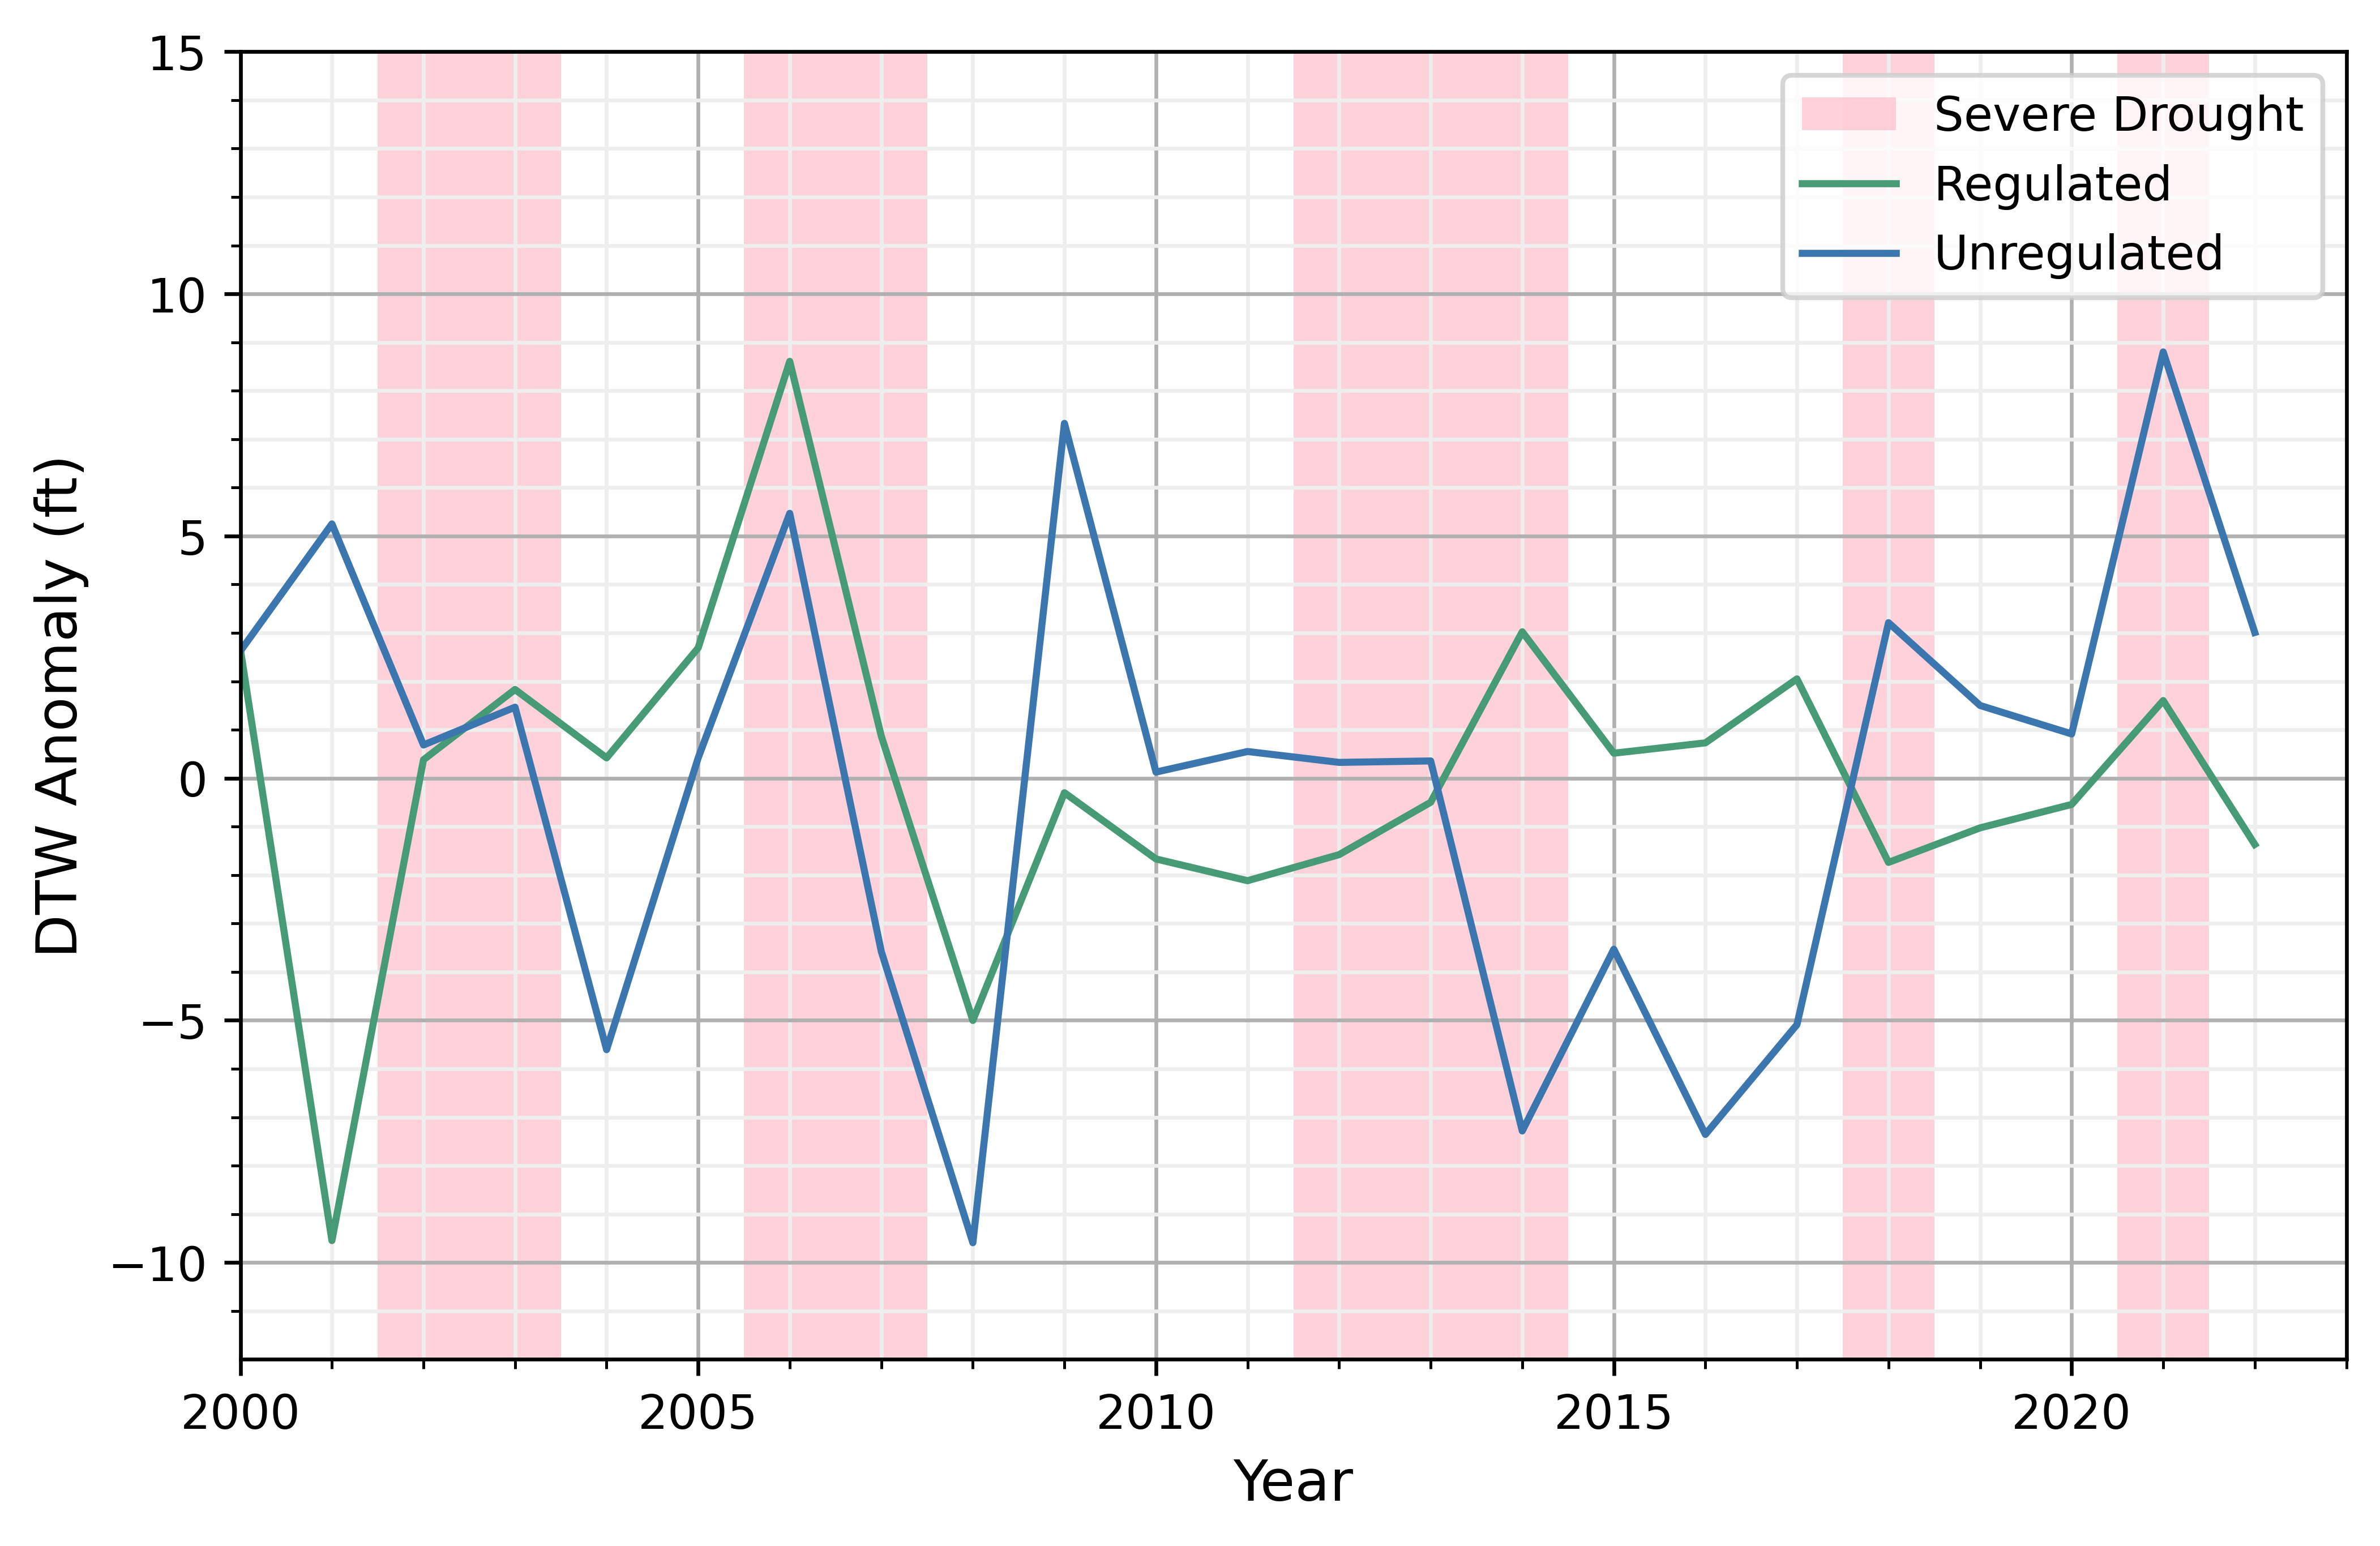

In [38]:
# For Depth to Water by regulation
ds = dtw_anomalys
min_yr = 2000
mx_yr = 2023
betterlabels = ['Regulated','Unregulated']

fig, ax = plt.subplots(1, 1, figsize = (8,5))

min_y = -12
max_y = 15
fsize = 12

# Drought Year Shading
a = 1988.5
b = 1990.5
c = 1995.5
d = 1996.5
e = 2020.5
f = 2021.5
g = 2001.5
h = 2003.5
i = 2005.5
j = 2007.5
k = 2011.5
l = 2014.5
m = 2017.5
n = 2018.5
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0, label="Severe Drought")
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)

ax.plot(ds['R'], label='Regulated', color=swdom, lw=1.5) 
ax.plot(ds['U'], label='Unregulated', color=GWdom, lw=1.5) 

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(min_y,max_y)
# ax.grid(True)
ax.grid(visible=True,which='major')
ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('DTW Anomaly (ft)',fontsize=fsize)
ax.minorticks_on()
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='upper right')

#Putting Grace on a secondary axis
# ax2 = ax.twinx()
# ax2.plot(grace_yearly['0'], label='State Average LWE', color='k',zorder=1)
# ax2.set_ylim([15, -15])
# ax2.set_ylabel(u'Δ LWE (cm)',fontsize=fsize)
# ax2.legend(loc='lower right')

# plt.savefig(figurepath+'Timeseries of DTW Anomalies for '+StudyArea, bbox_inches = 'tight')

Calculating Max Drawdown (maximum anomaly in the drought period)

In [41]:
# %% Average Anomalie for drought periods
ds = dtw_anomalys.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


dtw_max_anomalies = ds.groupby(['Status']).max()
dtw_max_anomalies
# ds

,R,U
Status,,
Drought 3,1.83,1.47
Drought 4,8.61,5.47
Drought 5,3.02,0.36
Drought 6,-1.74,3.21
Drought 7,1.60,8.80
Normal-Wet,2.69,7.33


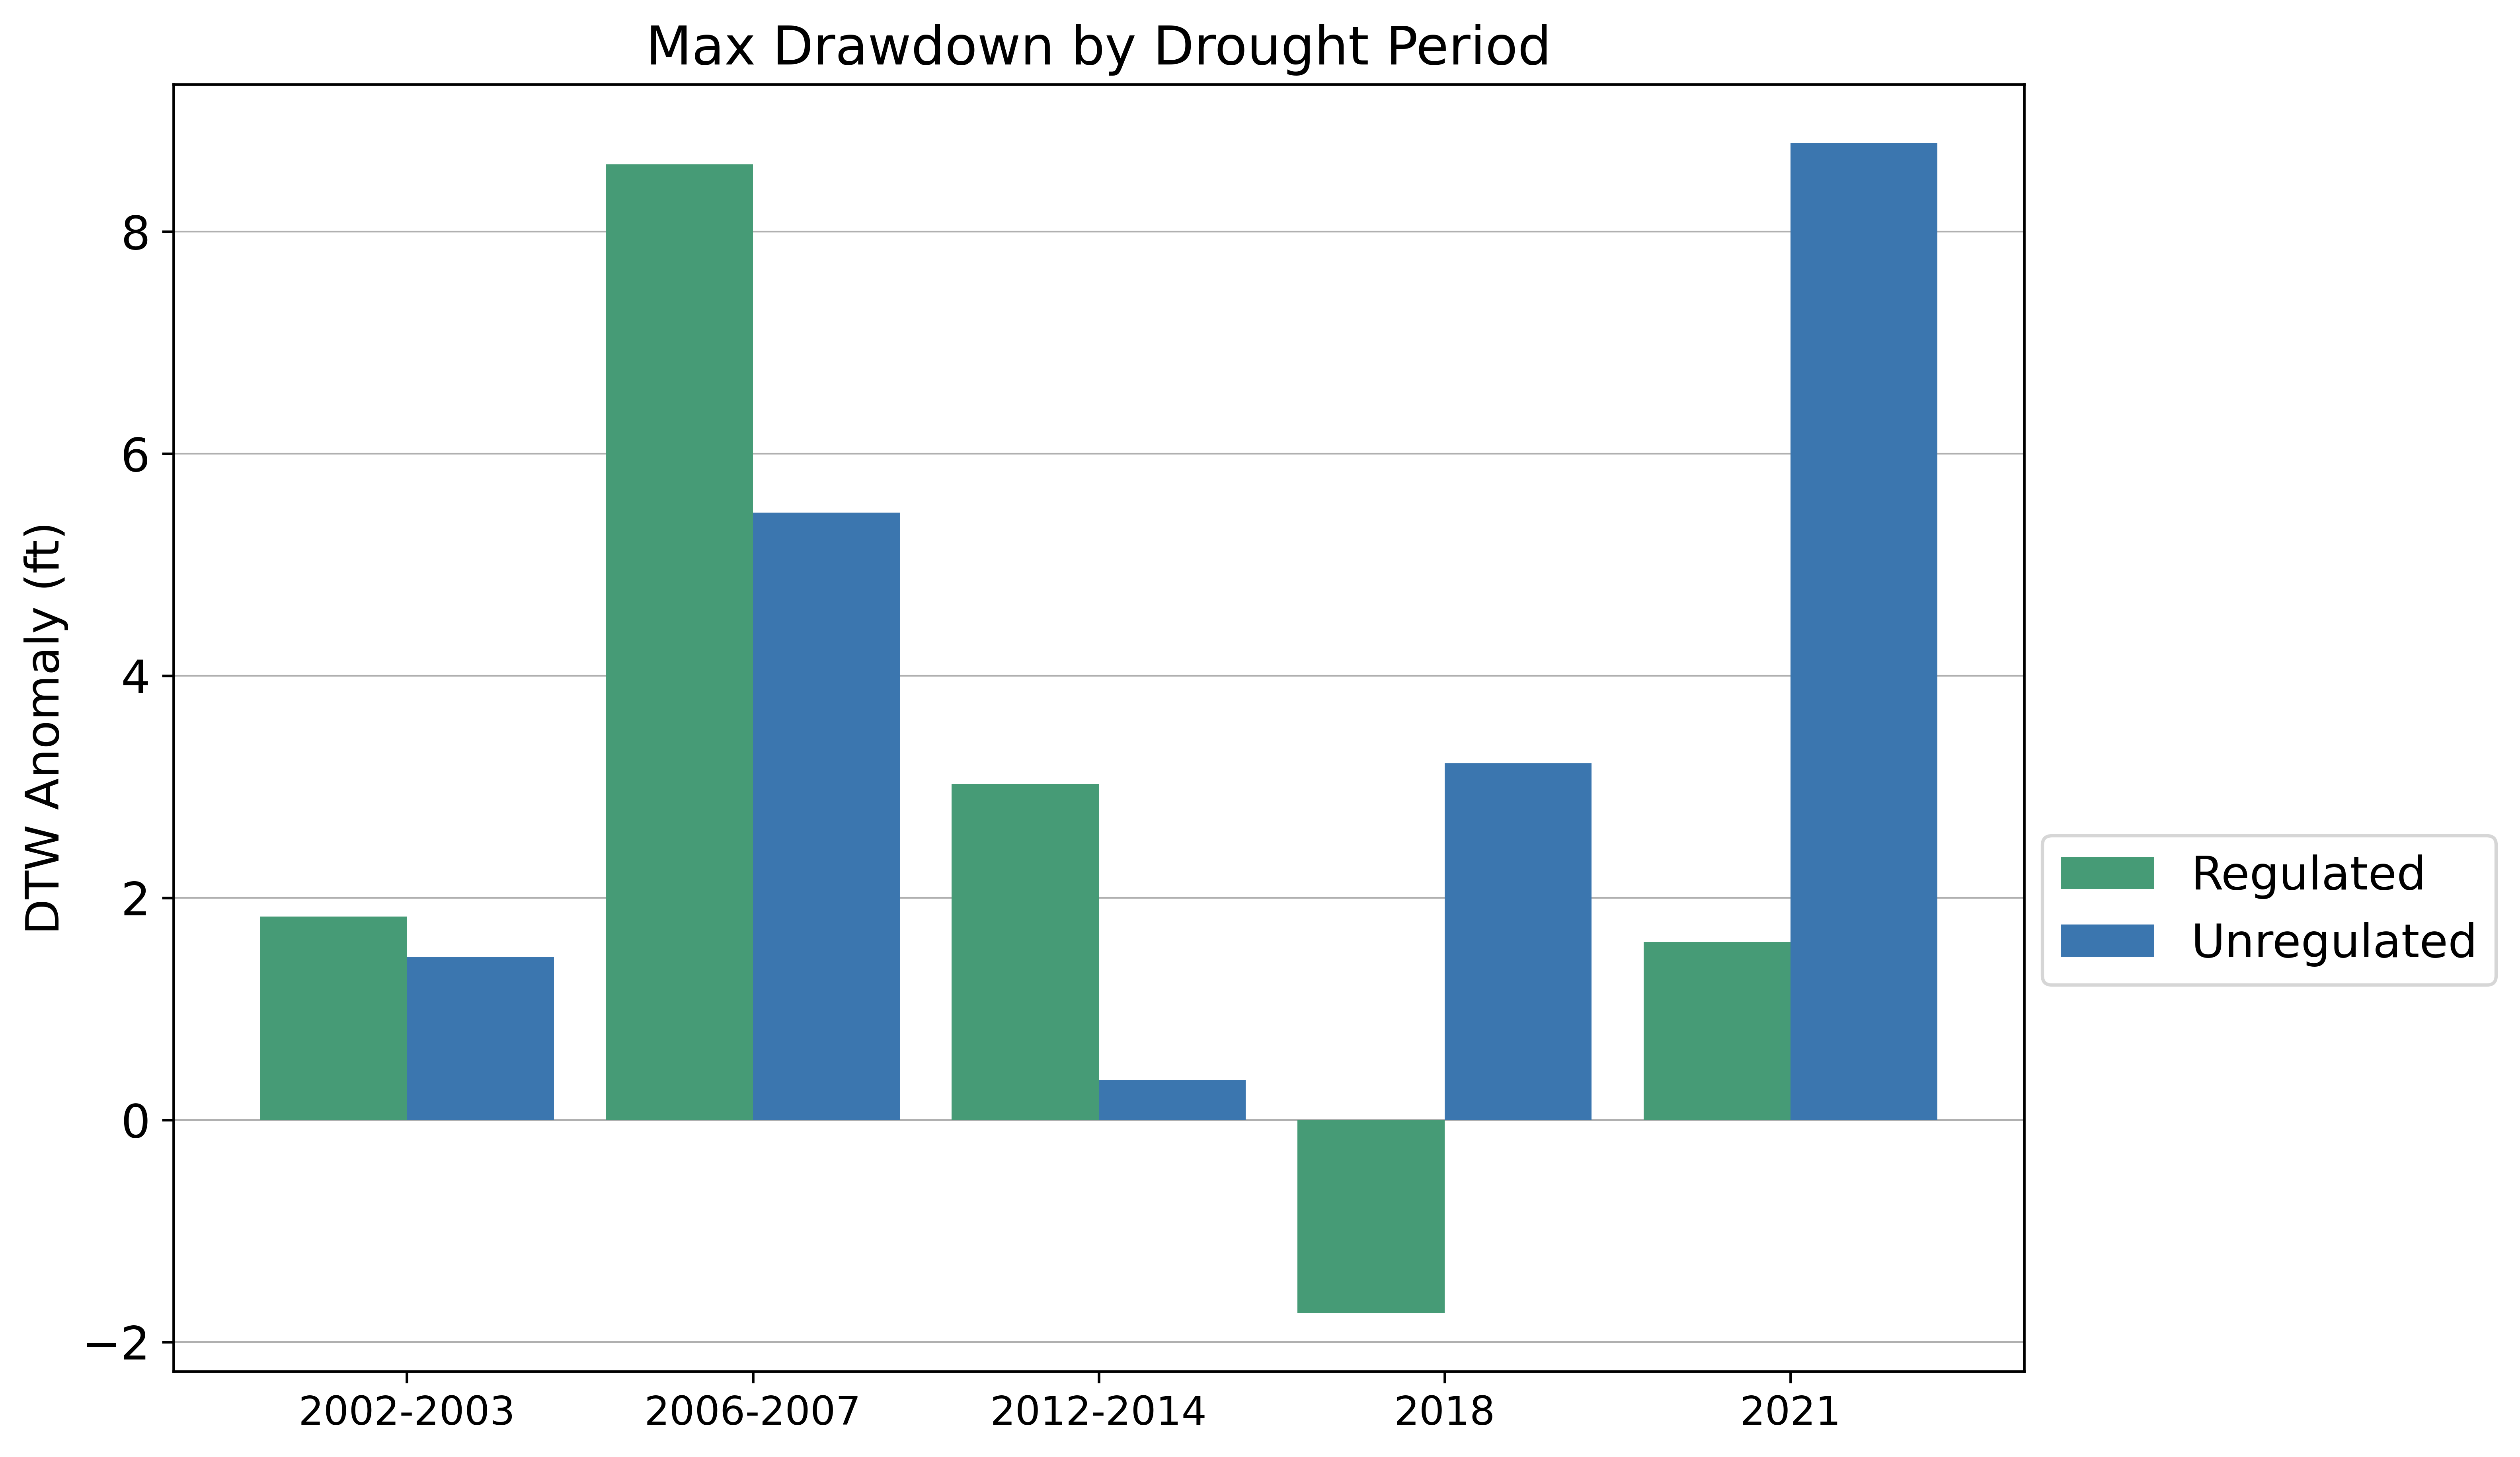

In [42]:
#%% Grouped Bar chart for drawdown (ft)
# name = 'Average DTW Anomalies by Drought Period and Groundwater Regulation'
name = 'Max Drawdown by Drought Period for '+StudyArea

yearlabels = [
                # "1989-1990"
        #       ,'1996',
              '2002-2003','2006-2007','2012-2014','2018','2021'
              ,'Normal/Wet Years'
        ]
# betterlabels = ['CAP','Regulated \n Groundwater','Surface \n Water','Unregulated \n Groundwater','Mixed \n GW/SW'] 
betterlabels = ['Regulated','Unregulated']

dtw_max_anomalies.index = yearlabels
dtw_max_anomalies = dtw_max_anomalies.transpose()

dtw_max_anomalies.index = betterlabels
del dtw_max_anomalies['Normal/Wet Years']
dtw_max_anomalies = dtw_max_anomalies.transpose()

# group_colors = ['lightsalmon','tomato','orangered','r','brown','indianred','steelblue']

# group_colors = [blind[5],blind[6],blind[2]
#                 ,blind[12],blind[11],blind[10]
#                 # ,blind[0] #black
#                 ]
group_colors = [swdom,GWdom]

horlabel = 'DTW Anomaly (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
dtw_max_anomalies.plot(figsize = (10,7),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
plt.title(name, fontsize = (fsize+2))
# plt.ylim([0,400])
plt.ylabel(horlabel, fontsize = fsize)
plt.xticks(rotation=0, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

# plt.savefig(outputpath+name+'_anomalies_groupedchart', bbox_inches = 'tight')

In [107]:
# New wells

static_geo2['INSTALLED'] = pd.to_datetime(static_geo2['INSTALLED'])
# static_geo2['INSTALLED'].describe()

static_geo2['In_year'] = static_geo2['INSTALLED'].dt.year
new_wells = pd.pivot_table(static_geo2, index=["In_year"], columns=["Regulation"], values=["INSTALLED"], dropna=False, aggfunc=len)
# new_wells = new_wells.reset_index()
new_wells.to_csv(outputpath_local+'Final_NewWells_'+StudyArea+'.csv')

In [110]:
# To get it formatted correctly

new_wells2 = pd.read_csv(outputpath_local+'Final_NewWells_'+StudyArea+'.csv',
                        header=2,
                        names = ['R','Res','U']
                        # names = [StudyArea]
                        , index_col=0)
new_wells2

,R,Res,U
1882.00,NaN,NaN,1.00
1890.00,NaN,NaN,1.00
1899.00,1.00,NaN,NaN
1900.00,2.00,1.00,5.00
1903.00,NaN,NaN,1.00
...,...,...,...
2019.00,688.00,9.00,631.00
2020.00,640.00,5.00,734.00
2021.00,701.00,2.00,802.00
2022.00,467.00,10.00,678.00


In [111]:
del new_wells2['Res']

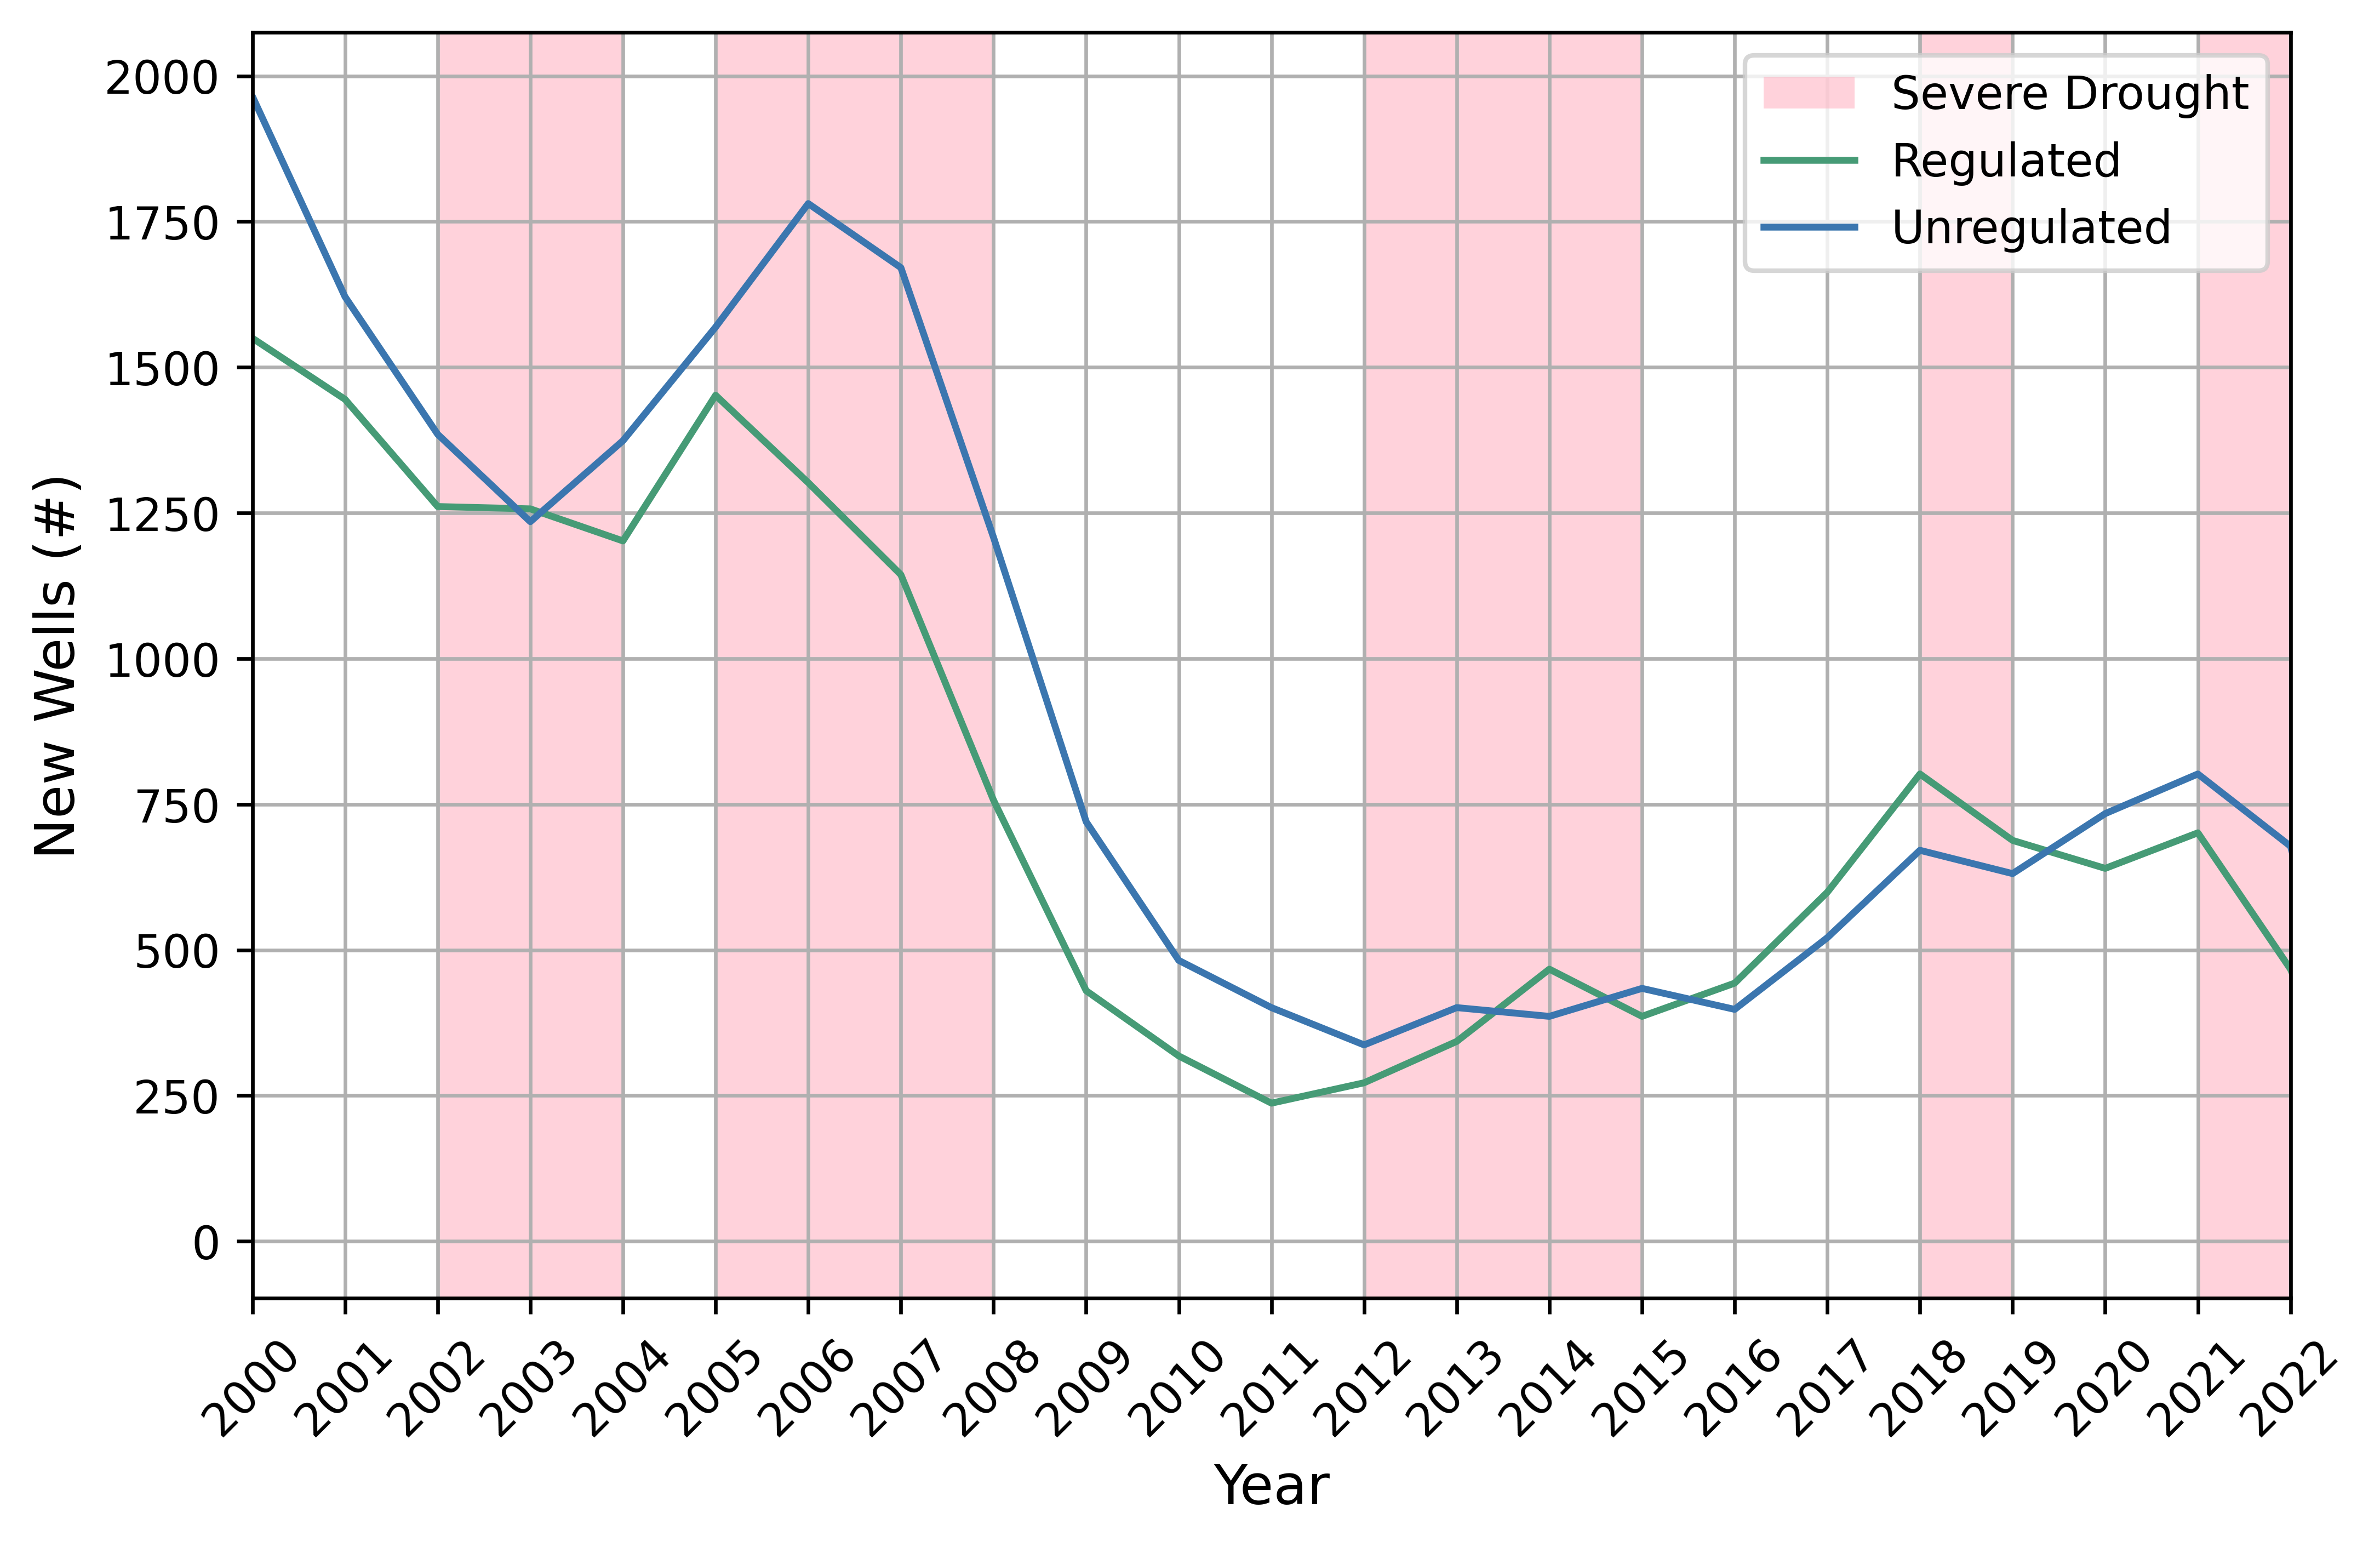

In [120]:

# For Depth to Water by regulation
ds = new_wells2
min_yr = 2000
mx_yr = 2022
betterlabels = ['Regulated','Unregulated']

fig, ax = plt.subplots(1, 1, figsize = (8,5))

min_y = -12
max_y = 15
fsize = 12
num_years = mx_yr - min_yr + 1
ax.set_xticks(np.linspace(min_yr, mx_yr, num_years))
ax.set_xticklabels(map(int, ax.get_xticks()))

# Drought Year Shading
a = 1988
b = 1990
c = 1995
d = 1996
e = 2021
f = 2022
g = 2002
h = 2004
i = 2005
j = 2008
k = 2012
l = 2015
m = 2018
n = 2019
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0, label="Severe Drought")
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)

ax.plot(ds['R'], label='Regulated', color=swdom, lw=1.5) 
ax.plot(ds['U'], label='Unregulated', color=GWdom, lw=1.5) 

ax.set_xlim(min_yr,mx_yr)
# ax.set_ylim(min_y,max_y)
# ax.grid(True)
ax.grid(visible=True,which='major')
ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('New Wells (#)',fontsize=fsize)
# ax.minorticks_on()
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='upper right')

#Putting Grace on a secondary axis
# ax2 = ax.twinx()
# ax2.plot(grace_yearly['0'], label='State Average LWE', color='k',zorder=1)
# ax2.set_ylim([15, -15])
# ax2.set_ylabel(u'Δ LWE (cm)',fontsize=fsize)
# ax2.legend(loc='lower right')

plt.savefig(figurepath+'Timeseries of New Wells for '+StudyArea, bbox_inches = 'tight')